Notebook to generate semisynthetic CML data from a RADOLAN image and to reconstruct fields from this data using Random Mixing.

# Import

In [1]:
import os
import sys

fpth = os.path.abspath(os.path.join('..','RMWSPy', 'cml_example'))
sys.path.append(fpth)
fpth = os.path.abspath(os.path.join('..','RMWSPy', 'rmwspy'))
sys.path.append(fpth)

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

import dask
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

import sparse

# copied from pycomlink to aviod dowloading conflicting libraries
from grid_intersection import get_grid_time_series_at_intersections
from grid_intersection import calc_sparse_intersect_weights_for_several_cmls
from grid_intersection import calc_intersect_weights

import datetime
from tqdm import tqdm
import yaml

import rain_data as cmlp
import RM_processing as rmp
from cml import *

import CRPS.CRPS as pscore
%load_ext autoreload
%autoreload 2

In [2]:
erlend_pth = os.path.abspath(os.path.join('..','..'))
sys.path.append(erlend_pth)
from RM_processing import create_blocks_from_lines
from RM_processing import generate_cmls_grid_intersects

from scipy.stats import norm, pearsonr

import gstools as gs
import os, shutil

# supress warnings from shapely
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
import pickle

In [3]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as tkr
from matplotlib.ticker import FormatStrFormatter
from matplotlib import colors

In [4]:
from skgstat import Variogram

In [5]:
from pyproj import CRS
from pyproj import Transformer

# prepare semisynthetic CML data from rad image

In [6]:
# define options
grid_point_location = "lower_left"     # for RADOLAN the pixel information is stored in the lower left pixel
outname = "cml_rain_from_rad"          # output file name

In [7]:
# load and slice radar data, note that the coordinates has bee shifted in order to hide the CML coordinates 
ds_rad = xr.open_dataset("./data/ds_rad_germany.nc")
ds_cml = xr.open_dataset("./data/ds_cml_germany.nc")

In [8]:
# radar at one timestep
t = "2021-06-20T00:15"
ds_rad_t = ds_rad.sel(time=t) 

In [9]:
# add extended CMLs (ued for illustration)
l = 5
x_off = []
y_off = []
for cml_id in ds_cml.cml_id:
    # Select CML 
    tar = ds_cml.sel(cml_id = cml_id)

    # Calculate angle and resulting length if we extend
    alpha = np.arctan((tar.y_b - tar.y_a)/(tar.x_b - tar.x_a))
    length1 = np.sqrt((tar.x_b + 5*np.cos(alpha) - tar.x_a)**2 + (tar.y_b + 5*np.sin(alpha) - tar.y_a)**2)
    length2 = np.sqrt((tar.x_b - 5*np.cos(alpha) - tar.x_a)**2 + (tar.y_b - 5*np.sin(alpha) - tar.y_a)**2)
    
    # extend in the direction that increases length
    if length1 > length2:
        x_off.append(tar.x_b.data + l*np.cos(alpha))
        y_off.append(tar.y_b.data + l*np.sin(alpha))
    else:
        x_off.append(tar.x_b.data - l*np.cos(alpha))
        y_off.append(tar.y_b.data - l*np.sin(alpha))

ds_cml = ds_cml.assign_coords(x_l = ('cml_id', x_off))
ds_cml = ds_cml.assign_coords(y_l = ('cml_id', y_off))


In [10]:
# Output reference system:
crs = CRS('EPSG:25832') # Europe 

# set source coordinates
crs_source = CRS('EPSG:4326') # latitude longitude wgs84

# Shifted coordinates in lat/lon
proj = Transformer.from_crs(crs, crs_source, always_xy=True)
lon_proj, lat_proj= proj.transform(ds_cml.x_l.data*1000, ds_cml.y_l.data*1000)
ds_cml = ds_cml.assign_coords(site_l_latitude = ('cml_id', lat_proj))
ds_cml = ds_cml.assign_coords(site_l_longitude = ('cml_id', lon_proj))

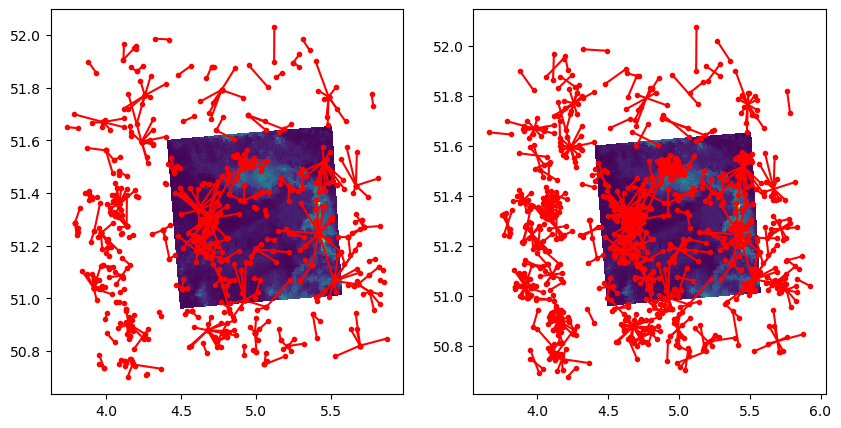

In [11]:
# plot the situation with short and long links
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
lower_shift = 30
ax[0].pcolormesh(ds_rad.longitudes, ds_rad.latitudes, ds_rad.sel(time =  "2021-06-20T00:40").rainfall_amount.data)
for device in ds_cml.cml_id:
    ax[0].plot([device.site_a_longitude, device.site_b_longitude],[
              device.site_a_latitude, device.site_b_latitude], '-r', marker='o', markersize =3)
    
ax[1].pcolormesh(ds_rad.longitudes, ds_rad.latitudes, ds_rad.sel(time =  "2021-06-20T00:40").rainfall_amount.data)
for device in ds_cml.cml_id:
    ax[1].plot([device.site_a_longitude, device.site_l_longitude],[
              device.site_a_latitude, device.site_l_latitude], '-r', marker='o', markersize =3)

In [12]:
# For normal link lengths
lats = dask.delayed(ds_rad.latitudes.load())
lons = dask.delayed(ds_rad_t.longitudes.load())

intersec_weights_list = []
cml_id_list = []

for cml_id, cml in tqdm(ds_cml.groupby("cml_id")):
    cml_id_list.append(cml_id)
    intersec_weights_list.append(
        dask.delayed(sparse.COO.from_numpy)(
            dask.delayed(calc_intersect_weights)(
                # dask.delayed(calc_intersect_weights)(
                x1_line=cml.site_a_longitude,
                y1_line=cml.site_a_latitude,
                x2_line=cml.site_b_longitude,
                y2_line=cml.site_b_latitude,
                x_grid=lons,  
                y_grid=lats,  
                grid_point_location=grid_point_location,
            )
        )
    )
    
intersec_weights_list = dask.compute(*intersec_weights_list)

# create mask with info whether a cml is on the rad grid
covered_by_rad_grid = []
for weight in tqdm(intersec_weights_list):
    if weight.sum() == 0:
        covered_by_rad_grid.append(False)
    elif weight.sum() > 0:
        covered_by_rad_grid.append(True)

da_intersec_weights_list = []
for cml_id, intersec_weights in zip(cml_id_list, intersec_weights_list):
    coords = ds_rad_t.coords
    coords["cml_id"] = cml_id
    da_intersec_weights_list.append(
        xr.DataArray(
            dims=("y", "x"),  
            coords=coords,
            data=intersec_weights,
        )
    )

da_intersec_weights = xr.concat(da_intersec_weights_list, dim="cml_id")
intersec_weights_list = dask.compute(*intersec_weights_list)

# create mask with info whether a cml is on the rad grid
covered_by_rad_grid = []
for weight in tqdm(intersec_weights_list):
    if weight.sum() == 0:
        covered_by_rad_grid.append(False)
    elif weight.sum() > 0:
        covered_by_rad_grid.append(True)

da_intersec_weights_list = []
for cml_id, intersec_weights in zip(cml_id_list, intersec_weights_list):
    coords = ds_rad_t.coords
    coords["cml_id"] = cml_id
    da_intersec_weights_list.append(
        xr.DataArray(
            dims=("y", "x"),  
            coords=coords,
            data=intersec_weights,
        )
    )

da_intersec_weights = xr.concat(da_intersec_weights_list, dim="cml_id")

# for time coordinates: 
cmls = []
for time in ds_rad.time.values.copy():
    # create new dataset for path averages
    ds_gridded_along_cml = xr.Dataset(
        coords={
            "time": time,
            "cml_id": da_intersec_weights.cml_id,
        },
    )
    
    # create path averages
    temp_list = []
    temp = dask.array.tensordot(
        ds_rad.sel(time = time).rainfall_amount.data, da_intersec_weights.data, axes=[[0, 1], [1, 2]]
    )
    ds_gridded_along_cml["R"] = ["cml_id"], temp.compute()    
    
    # Add CML coordinates (adding one dataset coordinate adds all the others)
    ds_gridded_along_cml.coords["site_a_latitude"] = ds_cml.site_a_latitude
    # add info whether link is in the area that is covered by the gridded data
    ds_gridded_along_cml["covered_by_rad_grid"] = ("cml_id", covered_by_rad_grid)

    # Erlend: Changed this line to avoid error
    ds_gridded_along_cml["covered_by_rad_reach"] = (
        "cml_id",
        (~ds_gridded_along_cml.R.isnull() & ds_gridded_along_cml.covered_by_rad_grid).values
    )
    
    cmls.append(ds_gridded_along_cml)
ds_gridded_along_cml = xr.concat(cmls, dim = 'time')

# dask seem to sett all time to last timestep? this fixes that. 
ds_gridded_along_cml['time'] = ds_rad.time

100%|███████████████████████████████████████| 430/430 [00:00<00:00, 2846.81it/s]


In [13]:
# For normal extended link lengths
lats = dask.delayed(ds_rad.latitudes.load())
lons = dask.delayed(ds_rad_t.longitudes.load())

intersec_weights_list = []
cml_id_list = []

for cml_id, cml in tqdm(ds_cml.groupby("cml_id")):
    cml_id_list.append(cml_id)
    intersec_weights_list.append(
        dask.delayed(sparse.COO.from_numpy)(
            dask.delayed(calc_intersect_weights)(
                # dask.delayed(calc_intersect_weights)(
                x1_line=cml.site_a_longitude,
                y1_line=cml.site_a_latitude,
                x2_line=cml.site_l_longitude,
                y2_line=cml.site_l_latitude,
                x_grid=lons,  
                y_grid=lats,  
                grid_point_location=grid_point_location,
            )
        )
    )
    
intersec_weights_list = dask.compute(*intersec_weights_list)

# create mask with info whether a cml is on the rad grid
covered_by_rad_grid = []
for weight in tqdm(intersec_weights_list):
    if weight.sum() == 0:
        covered_by_rad_grid.append(False)
    elif weight.sum() > 0:
        covered_by_rad_grid.append(True)

da_intersec_weights_list = []
for cml_id, intersec_weights in zip(cml_id_list, intersec_weights_list):
    coords = ds_rad_t.coords
    coords["cml_id"] = cml_id
    da_intersec_weights_list.append(
        xr.DataArray(
            dims=("y", "x"),  
            coords=coords,
            data=intersec_weights,
        )
    )

da_intersec_weights = xr.concat(da_intersec_weights_list, dim="cml_id")
intersec_weights_list = dask.compute(*intersec_weights_list)

# create mask with info whether a cml is on the rad grid
covered_by_rad_grid = []
for weight in tqdm(intersec_weights_list):
    if weight.sum() == 0:
        covered_by_rad_grid.append(False)
    elif weight.sum() > 0:
        covered_by_rad_grid.append(True)

da_intersec_weights_list = []
for cml_id, intersec_weights in zip(cml_id_list, intersec_weights_list):
    coords = ds_rad_t.coords
    coords["cml_id"] = cml_id
    da_intersec_weights_list.append(
        xr.DataArray(
            dims=("y", "x"),  
            coords=coords,
            data=intersec_weights,
        )
    )

da_intersec_weights = xr.concat(da_intersec_weights_list, dim="cml_id")

# for time coordinates: 
cmls = []
for time in ds_rad.time.values.copy():
    # create new dataset for path averages
    ds_gridded_along_cml_l = xr.Dataset(
        coords={
            "time": time,
            "cml_id": da_intersec_weights.cml_id,
        },
    )
    
    # create path averages
    temp_list = []
    temp = dask.array.tensordot(
        ds_rad.sel(time = time).rainfall_amount.data, da_intersec_weights.data, axes=[[0, 1], [1, 2]]
    )
    ds_gridded_along_cml_l["R_l"] = ["cml_id"], temp.compute()    
    
    # Add CML coordinates (adding one dataset coordinate adds all the others)
    ds_gridded_along_cml_l.coords["site_a_latitude"] = ds_cml.site_a_latitude
    # add info whether link is in the area that is covered by the gridded data
    ds_gridded_along_cml_l["covered_by_rad_grid"] = ("cml_id", covered_by_rad_grid)

    # Erlend: Changed this line to avoid error
    ds_gridded_along_cml_l["covered_by_rad_reach"] = (
        "cml_id",
        (~ds_gridded_along_cml_l.R_l.isnull() & ds_gridded_along_cml_l.covered_by_rad_grid).values
    )
    
    cmls.append(ds_gridded_along_cml_l)
ds_gridded_along_cml_l = xr.concat(cmls, dim = 'time')

# dask seem to sett all time to last timestep? this fixes that. 
ds_gridded_along_cml_l['time'] = ds_rad.time

100%|███████████████████████████████████████| 430/430 [00:00<00:00, 3136.66it/s]


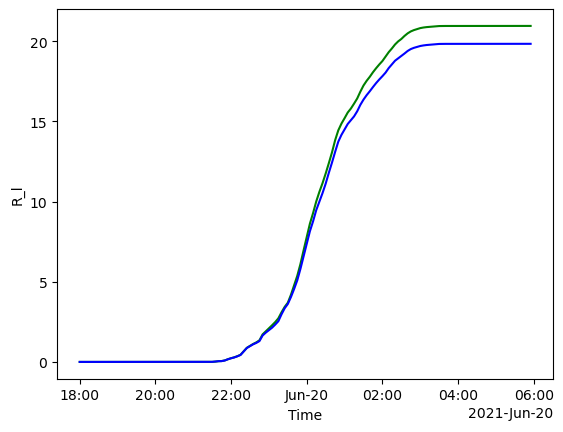

In [14]:
# less variability when we have longer links
ds_gridded_along_cml.R.std(dim = 'cml_id').cumsum(dim = 'time').plot.line(x = 'time', add_legend = False, color = 'green');
ds_gridded_along_cml_l.R_l.std(dim = 'cml_id').cumsum(dim = 'time').plot.line(x = 'time', add_legend = False, color = 'blue');

In [15]:
ds_gridded_along_cml['R_l'] = ds_gridded_along_cml_l.R_l

In [16]:
# overwrite existing netcdf if exists
if outname is not None:
    file = "./data/%s.nc"%outname
    ds_gridded_along_cml.to_netcdf(
        file + '_', encoding={"R": {"zlib": True}}
    )
    shutil.copy(file+'_', file) #overwrite existing
    os.remove(file+'_')

# Use CML data in RM algorithm
Here I use the CML data in all steps. CML midpoints are used for the estimation of the spatial model, the transformation function, and (optional, see flag `linear_constraints`) as linear constraints. CML paths are still considered at the end as nonlinear constraints.

**Note that I remove several CMLs.** The reason is that it is not possible (singular matrix) to estimate the spatial model with observations on the same grid point. I remove them completely now, though it would be possible to use them as nonlinear constraints still.

In [17]:
# define options
lin_constraints = False             # whether linear constraints should be considered
nonlin_constraints = True           # whether nonlinear constraints should be considered
nfields = 4                         # number of ensemble members
maskR = None                        # special functionality with masking, should always be None here
outfolder = "../../data/fields/"    # path to output folder

In [18]:
# def set_spatial_coordinates(ds_cml):

#     # coords
#     ds_cml["lat_center"] = (ds_cml.site_a_latitude + ds_cml.site_b_latitude) / 2
#     ds_cml["lon_center"] = (ds_cml.site_a_longitude + ds_cml.site_b_longitude) / 2

#     # project to radolan grid (mid-points and both poles)
#     y, x = cmlp.projRADOLAN(ds_cml.lat_center.values, ds_cml.lon_center.values)
#     y_a, x_a = cmlp.projRADOLAN(
#         lat=ds_cml.site_a_latitude.values, lon=ds_cml.site_a_longitude.values
#     )
#     y_b, x_b = cmlp.projRADOLAN(
#         lat=ds_cml.site_b_latitude.values, lon=ds_cml.site_b_longitude.values
#     )

#     ds_cml["y"] = ("cml_id", y)
#     ds_cml["x"] = ("cml_id", x)
#     ds_cml["y_a"] = ("cml_id", y_a)
#     ds_cml["x_a"] = ("cml_id", x_a)
#     ds_cml["y_b"] = ("cml_id", y_b)
#     ds_cml["x_b"] = ("cml_id", x_b)

#     ds_cml = ds_cml.set_coords(
#         ("lat_center", "lon_center", "y", "x", "y_a", "x_a", "y_b", "x_b")
#     )

#     return ds_cml

In [19]:
from pyproj import CRS
from pyproj import Transformer

In [20]:
ds_cml = xr.open_dataset("./data/cml_rain_from_rad.nc",)

In [21]:
ds_cml = ds_cml.assign_coords(y = ("cml_id", (ds_cml.y_a.values + ds_cml.y_b.values)/2))
ds_cml = ds_cml.assign_coords(x = ("cml_id", (ds_cml.x_a.values + ds_cml.x_b.values)/2))

In [22]:
# rad for one time step
ds_rad_t = ds_rad.sel(time=t)

In [23]:
# domain
ymin = ds_rad_t.y.min().values 
xmin = ds_rad_t.x.min().values
ymax = ds_rad_t.y.max().values
xmax = ds_rad_t.x.max().values

# domainsize defined by radolan image (ensure that y is first coordinate of rainfall amount)
domainsize = ds_rad_t.rainfall_amount.shape

# grid coords used for RM output (make sure to include last grid point by 
# adding a small number below the resolution of 1 km, e.g. 0.1)
ygrid=np.arange(ymin + 0.5, ymax - 0.5)
xgrid=np.arange(xmin + 0.5, xmax - 0.5)

In [24]:
# remove links outside grid
ds_cml = ds_cml.where(ds_cml.x_a > xgrid[0], drop= True)
ds_cml = ds_cml.where(ds_cml.x_b > xgrid[0], drop= True)
ds_cml = ds_cml.where(ds_cml.x_l > xgrid[0], drop= True)

ds_cml = ds_cml.where(ds_cml.x_a < xgrid[-1], drop= True)
ds_cml = ds_cml.where(ds_cml.x_b < xgrid[-1], drop= True)
ds_cml = ds_cml.where(ds_cml.x_l < xgrid[-1], drop= True)

ds_cml = ds_cml.where(ds_cml.y_a > ygrid[0], drop= True)
ds_cml = ds_cml.where(ds_cml.y_b > ygrid[0], drop= True)
ds_cml = ds_cml.where(ds_cml.y_l > ygrid[0], drop= True)

ds_cml = ds_cml.where(ds_cml.y_a < ygrid[-1], drop= True)
ds_cml = ds_cml.where(ds_cml.y_b < ygrid[-1], drop= True)
ds_cml = ds_cml.where(ds_cml.y_l < ygrid[-1], drop= True)

In [25]:
# shift towards origin
# Now these variables represent both the indice and length between them, they can also be represented in RM? 
ds_cml["y_a"] = (ds_cml.y_a - ymin).astype(int)
ds_cml["x_a"] = (ds_cml.x_a - xmin).astype(int)
ds_cml["y_b"] = (ds_cml.y_b - ymin).astype(int)
ds_cml["x_b"] = (ds_cml.x_b - xmin).astype(int)
ds_cml["y_l"] = (ds_cml.y_l - ymin).astype(int)
ds_cml["x_l"] = (ds_cml.x_l - xmin).astype(int)

# set midpoint
ds_cml["x"] = ((ds_cml.x_a + ds_cml.x_b)/2).astype(int)
ds_cml["y"] = ((ds_cml.y_a + ds_cml.y_b)/2).astype(int)

In [26]:
# adjust naming conventions
ds_cml = ds_cml.rename({"cml_id": "obs_id"})

In [27]:
# consider one time step only (in this case no time dim anyway)

# remove observations that fall on the same grid point
ds_cml = cmlp.label_combined_duplicates(ds_cml)
ds_cml = ds_cml.where(ds_cml.label_dupl, drop=True)

# remove some cmls that are duplicates
ds_cml['duplicate'] = np.logical_and( ds_cml.x_a == ds_cml.x_b, ds_cml.y_a == ds_cml.y_b)
ds_cml['duplicate'] = ds_cml['duplicate'] != 0 # 
ds_cml = ds_cml.where(ds_cml.duplicate == False, drop = True)

### Plot situation:

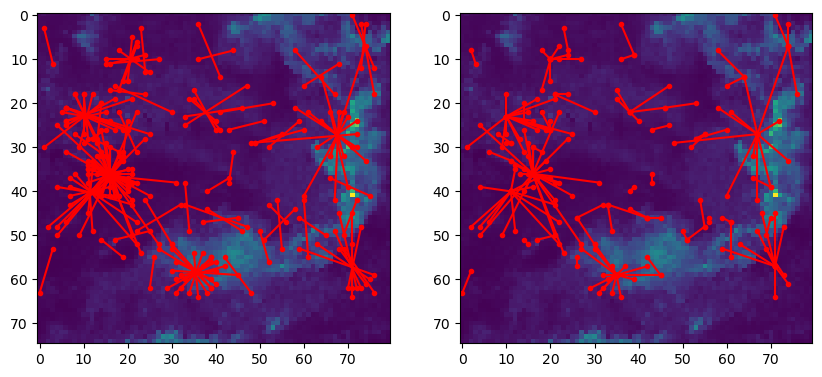

In [28]:
# plot map long links
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
lower_shift = 30
ax[0].imshow(ds_rad.sel(time =  "2021-06-20T00:40").rainfall_amount.values)
for device in ds_cml.obs_id:
    ax[0].plot([device.x_a, device.x_l],[
            device.y_a, device.y_l], '-r', marker='o', markersize =3)
    
# plot the situation, here x_a etc represents indices AND possition in km from origin
ax[1].imshow(ds_rad.sel(time =  "2021-06-20T00:40").rainfall_amount.values)
for device in ds_cml.obs_id:
    ax[1].plot([device.x_a, device.x_b],[
            device.y_a, device.y_b], '-r', marker='o', markersize =3)

# Calculate correlation lengths for all timesteps

In [29]:
time_start = '2021-06-20T00:00'
time_end = '2021-06-20T01:30'

In [ ]:
n_ests = 8 # number of estimates per 
cmod_midpoint_steps = {} # store data as timestep:[sim .. ]
cmod_dereg_steps = {}
cmod_true_steps = {}
eshel_midpoint_steps = {}
eshel_dereg_steps = {}
eshel_true_steps = {}

# Estiamte the mean value of the links
L = np.sqrt((ds_cml.y_a - ds_cml.y_b)**2 + (ds_cml.x_a - ds_cml.x_b)**2).mean().data

seed = 4
np.random.seed(seed)
for time in tqdm(ds_cml.sel(time = slice(time_start, time_end)).time):
    # create the timestep
    cmod_midpoint_steps[time.values] = []
    cmod_dereg_steps[time.values] = []
    cmod_true_steps[time.values] = []
    eshel_midpoint_steps[time.values] = []
    eshel_dereg_steps[time.values] = []
    eshel_true_steps[time.values] = []

    for _ in range(n_ests):
        # Calulate Copula model and marginal
        lin_prec = ds_cml.sel(time = time).R.values # test that we have obs
        if (lin_prec > 0).sum() >= 8: # require at leat 8 observations > 0 from CMLs
            # Method1: Midpoint
            lin_yx = np.vstack((ds_cml.sel(time = time).y.values, ds_cml.sel(time = time).x.values)).T.astype(int)
            lin_prec = ds_cml.sel(time = time).R.values
            keep = lin_prec > 0 # keep values larger than 0
            lin_prec = lin_prec[keep]
            lin_yx = lin_yx[keep, :]
            
            cmod_midpoint = rmp.calculate_copula(
                lin_yx,
                lin_prec*10,
                outputfile=None,
                covmods='exp',
                ntries=5,
                nugget=0.001,
                maxrange = 600,
                minrange = 1,
            ) 
            cmod_midpoint_steps[time.values].append(cmod_midpoint)
            
            # Method 2: True val from CML midpoint
            lin_yx = np.vstack((ds_cml.sel(time = time).y.values, ds_cml.sel(time = time).x.values)).T.astype(int)
            lin_prec = ds_rad.rainfall_amount.sel(time = time).isel(y = ds_cml.y, x = ds_cml.x)
            keep = lin_prec > 0 # keep values larger than 0
            lin_prec = lin_prec[keep]
            lin_yx = lin_yx[keep, :]
            
            cmod_true = rmp.calculate_copula(
                lin_yx, 
                lin_prec*10,
                outputfile=None,
                covmods='exp',
                ntries=5,
                nugget=0.001,
                maxrange = 600,
                minrange = 1,
            ) 
            cmod_true_steps[time.values].append(cmod_true)

            # Method 3: Dereg
            pos_x, pos_y = create_blocks_from_lines(np.hstack([
                ds_cml.sel(time = time).y_a.values.reshape(-1, 1),
                ds_cml.sel(time = time).y_b.values.reshape(-1, 1),
                ds_cml.sel(time = time).x_a.values.reshape(-1, 1),
                ds_cml.sel(time = time).x_b.values.reshape(-1, 1),
                ]), disc = 8)
            cml_yx_block = np.array([pos_y, pos_x]).transpose([1, 0, 2])
            lin_prec = ds_cml.sel(time = time).R.values
            cml_yx_block, lin_prec = cmlp.filter_nans_a(cml_yx_block, lin_prec)

            cmod_dereg = rmp.calculate_copula(
                cml_yx_block,
                lin_prec*10,
                outputfile=None,
                covmods='exp',
                ntries=5,
                nugget=0.001,
                mode='block',
                maxrange = float(cmod_midpoint.split('p')[-1][1:-3]),
                minrange = 1, # correlation lengths below this would be below grid size
            )
            cmod_dereg_steps[time.values].append(cmod_dereg)

            # Method 3 and 4: Midpoint and dereg
            lin_yx = np.vstack((ds_cml.sel(time = time).y.values, ds_cml.sel(time = time).x.values)).T.astype(int)
            lin_prec = ds_cml.sel(time = time).R.values
            lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)
            keep = lin_prec > 0 # keep values larger than 0
            lin_prec = lin_prec[keep]
            lin_yx = lin_yx[keep, :]
            
            V = Variogram(
                np.hstack([lin_yx[:, 1].reshape(-1, 1), lin_yx[:, 0].reshape(-1, 1)]), 
                np.log(lin_prec), # log transform to make data more gaussian
                model='exponential', 
                use_nugget=False,
                fit_bounds = ((1, 0), (600, np.log(lin_prec).var()*2)),
            )
            hr, sill, nugget = V.parameters
            hr = hr/3
            # store as RM variogram
            eshel_midpoint_steps[time.values].append('0.001 Nug(0.0) + 0.999 Exp('+ str(round(hr, 3)) + ')')
            eshel_dereg_steps[time.values].append('0.001 Nug(0.0) + 0.999 Exp('+ str(round(hr - 0.72*(1*L)**0.72, 3)) + ')')

            # Method 5: Eshel true
            lin_yx = np.vstack((ds_cml.sel(time = time).y.values, ds_cml.sel(time = time).x.values)).T.astype(int)
            lin_prec = ds_rad.rainfall_amount.sel(time = time).isel(y = ds_cml.y, x = ds_cml.x)
            lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)
            keep = lin_prec > 0 # keep values larger than 0
            lin_prec = lin_prec[keep]
            lin_yx = lin_yx[keep, :]
            V = Variogram(
                np.hstack([lin_yx[:, 1].reshape(-1, 1), lin_yx[:, 0].reshape(-1, 1)]), 
                np.log(lin_prec+0.0001), # log transform to make data more gaussian
                model='exponential', 
                use_nugget=False,
                fit_bounds = ((1, 0), (600, np.log(lin_prec).var()*2)),
            )
            hr, sill, nugget = V.parameters
            hr = hr/3
            # store as RM variogram
            eshel_true_steps[time.values].append('0.001 Nug(0.0) + 0.999 Exp('+ str(round(hr, 3)) + ')')
        
        else:
            cmod_midpoint_steps[time.values].append(np.nan)
            cmod_dereg_steps[time.values].append(np.nan)
            cmod_true_steps[time.values].append(np.nan)
            eshel_midpoint_steps[time.values].append(np.nan)
            eshel_dereg_steps[time.values].append(np.nan)
            eshel_true_steps[time.values].append(np.nan)


In [ ]:
# get estimated range (for plotting)
cmod_midpoint_plot = {}
cmod_true_plot = {}
cmod_dereg_plot = {}
cmod_eshelmid_plot = {}
cmod_esheldereg_plot = {}
cmod_esheltrue_plot = {}

for time in tqdm(ds_cml.sel(time = slice(time_start, time_end)).time):
    cmod_midpoint_plot[time.values] = []
    cmod_true_plot[time.values] = []
    cmod_dereg_plot[time.values] = []
    cmod_eshelmid_plot[time.values] = []
    cmod_esheldereg_plot[time.values] = []
    cmod_esheltrue_plot[time.values] = []

    for i in range(n_ests):
        if pd.isnull(cmod_midpoint_steps[time.values][i]):
            cmod_midpoint_plot[time.values].append(np.nan)
            cmod_true_plot[time.values].append(np.nan)
            cmod_dereg_plot[time.values].append(np.nan)
            cmod_eshelmid_plot[time.values].append(np.nan)
            cmod_esheldereg_plot[time.values].append(np.nan)
            cmod_esheltrue_plot[time.values].append(np.nan)

        else:
            cmod_midpoint_plot[time.values].append(float(cmod_midpoint_steps[time.values][i].split()[-1][4:-1]))
            cmod_true_plot[time.values].append(float(cmod_true_steps[time.values][i].split()[-1][4:-1]))
            cmod_dereg_plot[time.values].append(float(cmod_dereg_steps[time.values][i].split()[-1][4:-1]))
            cmod_eshelmid_plot[time.values].append(float(eshel_midpoint_steps[time.values][i].split()[-1][4:-1]))
            cmod_esheldereg_plot[time.values].append(float(eshel_dereg_steps[time.values][i].split()[-1][4:-1]))
            cmod_esheltrue_plot[time.values].append(float(eshel_true_steps[time.values][i].split()[-1][4:-1]))

df_dereg = pd.DataFrame(cmod_dereg_plot).T
df_true = pd.DataFrame(cmod_true_plot).T
df_midpoint = pd.DataFrame(cmod_midpoint_plot).T
df_eshelmidpoint = pd.DataFrame(cmod_eshelmid_plot).T
df_esheldereg = pd.DataFrame(cmod_esheldereg_plot).T
df_esheltrue = pd.DataFrame(cmod_esheltrue_plot).T

<Axes: >

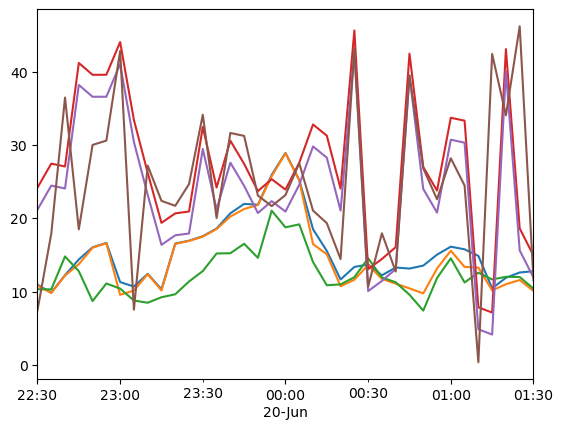

In [48]:
df_midpoint.mean(axis = 1).plot()
df_dereg.mean(axis = 1).plot()
df_true.mean(axis = 1).plot()
df_eshelmidpoint.mean(axis = 1).plot()
df_esheldereg.mean(axis = 1).plot()
df_esheltrue.mean(axis = 1).plot()


In [ ]:
# # # uncomment to save again
fields_5min = [df_dereg, df_midpoint, df_true, df_eshelmidpoint, df_esheldereg, df_esheltrue]

with open('/home/erlend/Downloads/fields_germany_variograms.pickle', 'wb') as handle:
    pickle.dump(fields_5min, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
# run top part of notebook (sample CMLs etc) before running this
with open(r'/home/erlend/Downloads/fields_germany_variograms.pickle', "rb") as input_file: 
    [df_dereg, df_midpoint, df_true, df_eshelmidpoint, df_esheldereg, df_esheltrue] = pickle.load(input_file)

# Condition stochastic fields for all timesteps 

In [31]:
nfields = 100 # number of fields to generate
N = 70 # number of samples from conditioned fields and real field 
N_samples = 8 # number of random fields to estimate from (must be lower than nfields)

synthetic_gridsize_yx = domainsize
time_iterate = ds_cml.sel(time = slice(time_start, time_end)).time

In [32]:
# Condition and evaluate fields for MIDPOINT METHOD
# use average of link for variogram and marginal
copula_midpoint = {'gaussian_range_conditioned': [], 'field_conditioned': []}
seed = 1
for time in time_iterate:
    if np.isnan(df_midpoint.loc[time.values]).any():
        copula_midpoint['gaussian_range_conditioned'].append(np.zeros(N_samples)*np.nan)
        copula_midpoint['field_conditioned'].append(
            np.zeros([nfields, synthetic_gridsize_yx[0], synthetic_gridsize_yx[1]])*np.nan) 
    else: 
        cml_prec = ds_cml.sel(time = time).R.values.ravel()

        # create nonlinear integrals for RM
        cml_yx = np.vstack(
            (
                ds_cml.sel(time = time).y_a.values,
                ds_cml.sel(time = time).x_a.values,
                ds_cml.sel(time = time).y_b.values,
                ds_cml.sel(time = time).x_b.values,
            )
        ).T.astype(int)
        cml_yx, cml_prec = cmlp.filter_nans_a(cml_yx, cml_prec)
        marginal = rmp.calculate_marginal(cml_prec*10) 
        
        # load estimated model, here use mean of all estimates
        cmod = '0.001 Nug(0.0) + 0.999 Exp(' + str(df_midpoint.loc[time.values].mean()) + ')'

        # condition fields
        nonlin_integrals = rmp.nl_integrals(cml_yx) 
        my_CMLModel = CMLModel(cml_prec, marginal, nonlin_integrals)

        CS = RMWS(
            my_CMLModel,
            domainsize=synthetic_gridsize_yx,
            covmod=cmod,
            nFields=nfields,
            cp=None,
            cv=None,
            le_cp=None,
            le_cv=None,
            optmethod="circleopt",
            minObj=0.4,
            maxbadcount=30,
            maxiter=100,
            pyfftwmode=True,
            seed=seed,
            tstep="aaa",
        )
        CS()
        final_fields = rmp.backtransform(CS.finalFields, marginal)
        del CS
        
        # investigate the spatial structure of the final fields
        ranges_from_field = [] 
        for i in range(N_samples):
            x_min = np.min([ds_cml.x_a, ds_cml.x_b]).astype(int)
            x_max = np.max([ds_cml.x_a, ds_cml.x_b]).astype(int)
            y_min = np.min([ds_cml.y_a, ds_cml.y_b]).astype(int)
            y_max = np.max([ds_cml.y_a, ds_cml.y_b]).astype(int)
            y = np.random.randint(y_min, y_max, size=N)
            x = np.random.randint(x_min, x_max, size=N)

            # a and b is the same for points, thus we can just use that
            lin_yx = np.vstack((y.ravel(), x.ravel())).T.astype(int)
            lin_prec = final_fields[i, y, x]
            
            # remove duplicates
            unique_rows, unique_indices = np.unique(lin_yx, axis=0, return_index=True)
            lin_yx = lin_yx[unique_indices, :]
            lin_prec = lin_prec[unique_indices]
            
            if (lin_prec.size > 20) and ((lin_prec > 0).sum()/lin_prec.size > 0.5):
                cmod = rmp.calculate_copula( 
                    lin_yx,
                    lin_prec*10,
                    outputfile=None,
                    covmods='exp',
                    ntries=6,
                    nugget=0.001,
                )
                ranges_from_field.append(float(cmod.split()[-1][4:-1]))
            else:
                ranges_from_field.append(np.nan)

        # store statistics
        copula_midpoint['gaussian_range_conditioned'].append(np.array(ranges_from_field))
        copula_midpoint['field_conditioned'].append(final_fields)     
    print(time.values)


2021-06-20T00:00:00.000000000
2021-06-20T00:05:00.000000000
2021-06-20T00:10:00.000000000
2021-06-20T00:15:00.000000000
2021-06-20T00:20:00.000000000
2021-06-20T00:25:00.000000000
2021-06-20T00:30:00.000000000
2021-06-20T00:35:00.000000000
2021-06-20T00:40:00.000000000
2021-06-20T00:45:00.000000000
2021-06-20T00:50:00.000000000
2021-06-20T00:55:00.000000000
2021-06-20T01:00:00.000000000
2021-06-20T01:05:00.000000000
2021-06-20T01:10:00.000000000
2021-06-20T01:15:00.000000000
2021-06-20T01:20:00.000000000
2021-06-20T01:25:00.000000000
2021-06-20T01:30:00.000000000


In [33]:
# Condition and evaluate fields for TRUE METHOD
# Use true midpoint for variogram and marginal
copula_true = {'gaussian_range_conditioned': [], 'field_conditioned': []}
seed = 1
for time in time_iterate:
    if np.isnan(df_true.loc[time.values]).any():
        copula_true['gaussian_range_conditioned'].append(np.zeros(N_samples)*np.nan)
        copula_true['field_conditioned'].append(
            np.zeros([nfields, synthetic_gridsize_yx[0], synthetic_gridsize_yx[1]])*np.nan) 
    else: 
        cml_prec = ds_cml.sel(time = time).R.values.ravel()

        # create nonlinear integrals for RM
        cml_yx = np.vstack(
            (
                ds_cml.sel(time = time).y_a.values,
                ds_cml.sel(time = time).x_a.values,
                ds_cml.sel(time = time).y_b.values,
                ds_cml.sel(time = time).x_b.values,
            )
        ).T.astype(int)
        
        cml_yx, cml_prec = cmlp.filter_nans_a(cml_yx, cml_prec)
        
        # estimate marginal from true  midpoint (used as transformation function)
        lin_prec = ds_rad.rainfall_amount.sel(time = time).isel(y = ds_cml.y, x = ds_cml.x).values  
        marginal = rmp.calculate_marginal(lin_prec*10) # kde is (supposedly) better with this *10, if you remove it: check backtransform under RM_processing

        # load estimated model, here use mean of all estimates
        cmod = '0.001 Nug(0.0) + 0.999 Exp(' + str(df_true.loc[time.values].mean()) + ')'

        # condition fields
        nonlin_integrals = rmp.nl_integrals(cml_yx) 
        my_CMLModel = CMLModel(cml_prec, marginal, nonlin_integrals) # use full CML for conditioning

        CS = RMWS(
            my_CMLModel,
            domainsize=synthetic_gridsize_yx,
            covmod=cmod,
            nFields=nfields,
            cp=None,
            cv=None,
            le_cp=None,
            le_cv=None,
            optmethod="circleopt",
            minObj=0.4,
            maxbadcount=30,
            maxiter=100,
            pyfftwmode=True,
            seed=seed,
            tstep="aaa",
        )
        CS()
        final_fields = rmp.backtransform(CS.finalFields, marginal)
        del CS
        
        # investigate the spatial structure of the final fields
        ranges_from_field = [] 
        for i in range(N_samples):
            x_min = np.min([ds_cml.x_a, ds_cml.x_b]).astype(int)
            x_max = np.max([ds_cml.x_a, ds_cml.x_b]).astype(int)
            y_min = np.min([ds_cml.y_a, ds_cml.y_b]).astype(int)
            y_max = np.max([ds_cml.y_a, ds_cml.y_b]).astype(int)
            y = np.random.randint(y_min, y_max, size=N)
            x = np.random.randint(x_min, x_max, size=N)

            # a and b is the same for points, thus we can just use that
            lin_yx = np.vstack((y.ravel(), x.ravel())).T.astype(int)
            lin_prec = final_fields[i, y, x]
            
            # remove duplicates
            unique_rows, unique_indices = np.unique(lin_yx, axis=0, return_index=True)
            lin_yx = lin_yx[unique_indices, :]
            lin_prec = lin_prec[unique_indices]
            
            if (lin_prec.size > 20) and ((lin_prec > 0).sum()/lin_prec.size > 0.5):
                cmod = rmp.calculate_copula( 
                    lin_yx,
                    lin_prec*10,
                    outputfile=None,
                    covmods='exp',
                    ntries=6,
                    nugget=0.001,

                )
                ranges_from_field.append(float(cmod.split()[-1][4:-1]))
            else:
                ranges_from_field.append(np.nan)

        # store statistics
        copula_true['gaussian_range_conditioned'].append(np.array(ranges_from_field))
        copula_true['field_conditioned'].append(final_fields)     
    print(time.values)


2021-06-20T00:00:00.000000000
2021-06-20T00:05:00.000000000
2021-06-20T00:10:00.000000000
2021-06-20T00:15:00.000000000
2021-06-20T00:20:00.000000000
2021-06-20T00:25:00.000000000
2021-06-20T00:30:00.000000000
2021-06-20T00:35:00.000000000
2021-06-20T00:40:00.000000000
2021-06-20T00:45:00.000000000
2021-06-20T00:50:00.000000000
2021-06-20T00:55:00.000000000
2021-06-20T01:00:00.000000000
2021-06-20T01:05:00.000000000
2021-06-20T01:10:00.000000000
2021-06-20T01:15:00.000000000
2021-06-20T01:20:00.000000000
2021-06-20T01:25:00.000000000
2021-06-20T01:30:00.000000000


In [34]:
# Condition and evaluate fields for DEREG METHOD
# use cml average for marginal, dereg method for variogram
copula_dereg = {'gaussian_range_conditioned': [], 'field_conditioned': []}
for time in time_iterate:
    if np.isnan(df_dereg.loc[time.values]).any():
        copula_dereg['gaussian_range_conditioned'].append(np.zeros(N_samples)*np.nan)
        copula_dereg['field_conditioned'].append(
            np.zeros([nfields, synthetic_gridsize_yx[0], synthetic_gridsize_yx[1]])*np.nan) 
        
    else: 
        cml_prec = ds_cml.sel(time = time).R.values.ravel()

        # create nonlinear integrals for RM
        cml_yx = np.vstack(
            (
                ds_cml.sel(time = time).y_a.values,
                ds_cml.sel(time = time).x_a.values,
                ds_cml.sel(time = time).y_b.values,
                ds_cml.sel(time = time).x_b.values,
            )
        ).T.astype(int)
        cml_yx, cml_prec = cmlp.filter_nans_a(cml_yx, cml_prec)
        marginal = rmp.calculate_marginal(cml_prec*10)# kde is (supposedly) better with this *10, if you remove it: check backtransform under RM_processing

        # load estimated model, here use mean of all estimates
        cmod = '0.001 Nug(0.0) + 0.999 Exp(' + str(df_dereg.loc[time.values].mean()) + ')'

        # condition fields
        nonlin_integrals = rmp.nl_integrals(cml_yx) 
        my_CMLModel = CMLModel(cml_prec, marginal, nonlin_integrals)

        CS = RMWS(
            my_CMLModel,
            domainsize=synthetic_gridsize_yx,
            covmod=cmod,
            nFields=nfields,
            cp=None,
            cv=None,
            le_cp=None,
            le_cv=None,
            optmethod="circleopt",
            minObj=0.4,
            maxbadcount=30,
            maxiter=100,
            pyfftwmode=True,
            seed=seed,
            tstep="aaa",
        )
        CS()
        final_fields = rmp.backtransform(CS.finalFields, marginal) 

        # investigate the spatial structure of the final fields
        ranges_from_field = [] 
        for i in range(N_samples):
            x_min = np.min([ds_cml.x_a, ds_cml.x_b]).astype(int)
            x_max = np.max([ds_cml.x_a, ds_cml.x_b]).astype(int)
            y_min = np.min([ds_cml.y_a, ds_cml.y_b]).astype(int)
            y_max = np.max([ds_cml.y_a, ds_cml.y_b]).astype(int)
            y = np.random.randint(y_min, y_max, size=N)
            x = np.random.randint(x_min, x_max, size=N)

            # a and b is the same for points, thus we can just use that
            lin_yx = np.vstack((y.ravel(), x.ravel())).T.astype(int)
            lin_prec = final_fields[i, y, x]
            
            unique_rows, unique_indices = np.unique(lin_yx, axis=0, return_index=True)
            lin_yx = lin_yx[unique_indices, :]
            lin_prec = lin_prec[unique_indices]
            
            if (lin_prec > 0).sum()/lin_prec.size > 0.5:
                cmod = rmp.calculate_copula( 
                    lin_yx,
                    lin_prec*10,
                    outputfile=None,
                    covmods='exp',
                    ntries=6,
                    nugget=0.001,
                )
                ranges_from_field.append(float(cmod.split()[-1][4:-1]))
            else:
                ranges_from_field.append(np.nan)

        # store statistics
        copula_dereg['gaussian_range_conditioned'].append(np.array(ranges_from_field))
        copula_dereg['field_conditioned'].append(final_fields)
    print(time.values)


2021-06-20T00:00:00.000000000
2021-06-20T00:05:00.000000000
2021-06-20T00:10:00.000000000
2021-06-20T00:15:00.000000000
2021-06-20T00:20:00.000000000
2021-06-20T00:25:00.000000000
2021-06-20T00:30:00.000000000
2021-06-20T00:35:00.000000000
2021-06-20T00:40:00.000000000
2021-06-20T00:45:00.000000000
2021-06-20T00:50:00.000000000
2021-06-20T00:55:00.000000000
2021-06-20T01:00:00.000000000
2021-06-20T01:05:00.000000000
2021-06-20T01:10:00.000000000
2021-06-20T01:15:00.000000000
2021-06-20T01:20:00.000000000
2021-06-20T01:25:00.000000000
2021-06-20T01:30:00.000000000


In [35]:
# # # # uncomment to save again
fields_5min = [copula_midpoint, copula_true, copula_dereg]
with open('/home/erlend/Downloads/fields_germany.pickle', 'wb') as handle:
    pickle.dump(fields_5min, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [32]:
# run top part of notebook (sample CMLs etc) before running this
with open(r'/home/erlend/Downloads/fields_germany.pickle', "rb") as input_file: 
    [copula_midpoint, copula_true, copula_dereg] = pickle.load(input_file)

In [33]:
copula_midpoint['field_conditioned'] = np.array(copula_midpoint['field_conditioned'])
copula_dereg['field_conditioned'] = np.array(copula_dereg['field_conditioned'])
copula_true['field_conditioned'] = np.array(copula_true['field_conditioned'])

copula_midpoint['gaussian_range_conditioned'] = np.array(copula_midpoint['gaussian_range_conditioned'])
copula_dereg['gaussian_range_conditioned'] = np.array(copula_dereg['gaussian_range_conditioned'])
copula_true['gaussian_range_conditioned'] = np.array(copula_true['gaussian_range_conditioned'])

# Plot 1: Rainfields

In [40]:
import matplotlib.ticker as ticker

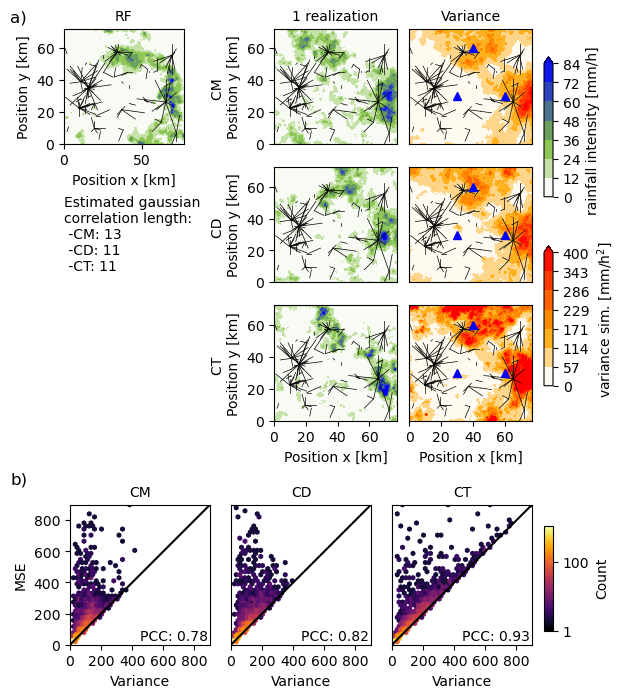

In [119]:
# which random fields to show, in general they vary much
time_plot = '2021-06-20T00:40'
to_mmh = 12

time_t = np.argmax((time_iterate == time_iterate.sel(time = time_plot, method = 'nearest')).values)
q = 0.95
isel = 2
n_levels = 8
fig = plt.figure(figsize =(6, 7))

#cmap_colors = [(1, 1, 1),(0.5, 0.75, 0.25), (0, 0, 1)]  # white -> light green -> dark blue
cmap_colors = [(0, 'white'), 
               (0.05, 'white'), 
               (0.4, (0.5, 0.75, 0.25)), 
               (1, 'blue')]  # white -> green-yellow mix -> dark blue
cmap = LinearSegmentedColormap.from_list("mycmap", cmap_colors)

cmap_colors = [(0, 'white'), 
               (0.05, 'white'), 
               (0.4, 'orange'), 
               (1, 'red')]  # white -> green-yellow mix -> dark blue
cmap_var = LinearSegmentedColormap.from_list("mycmap", cmap_colors)

thresh = 0

linewidth_set= 0.5
gs_cml = GridSpec(3, 1, left=0.09, right=0.29, top = 0.96, bottom=0.4)
min_val = 0
max_val = 7*to_mmh

min_val_var = 0
max_val_var = 5*(to_mmh**2)/1.8
levels = np.linspace(0, max_val, n_levels)
levels_var = np.linspace(0, max_val_var, n_levels)
ax = []
ax.append(fig.add_subplot(gs_cml[0]))
ax.append(fig.add_subplot(gs_cml[1]))
gs2 = GridSpec(3, 2, wspace=0.1, left=0.44, right=0.87, top = 0.96, bottom=0.4)
ax.append(fig.add_subplot(gs2[0]))
ax.append(fig.add_subplot(gs2[1]))
ax.append(fig.add_subplot(gs2[2]))
ax.append(fig.add_subplot(gs2[3]))
ax.append(fig.add_subplot(gs2[4]))
ax.append(fig.add_subplot(gs2[5]))


xgrid_plot = ds_rad.x.values - ds_rad.x.values.min()
ygrid_plot = ds_rad.y.values - ds_rad.y.values.min()

X, Y = np.meshgrid(xgrid_plot, ygrid_plot)

# plot the original field
im = ax[0].contourf(X, Y, 
                    ds_rad.sel(time =  time_plot).rainfall_amount.values*to_mmh, 
                    levels = levels, 
                    vmin=min_val, 
                    vmax=max_val,
                    cmap=cmap,
                    extend="max"    
                   )

for device in ds_cml.obs_id:
    ax[0].plot([xgrid_plot[device.x_a], xgrid_plot[device.x_b]],[ygrid_plot[device.y_a], ygrid_plot[device.y_b]], '-k', 
               markersize =linewidth_set, linewidth = linewidth_set)
ax[0].set_title('RF', fontsize=10)
ax[0].set_xlabel('Position x [km]', fontsize=10)
ax[0].set_ylabel('Position y [km]', fontsize=10)

#fig.delaxes(ax[1, 0])
ax[1].text(0, 0.1, 'Estimated gaussian\ncorrelation length: \n -CM: ' + f"{df_midpoint.loc[time_plot].mean():.0f}" + '\n -CD: ' + f"{df_dereg.loc[time_plot].mean():.0f}" + '\n -CT: ' + f"{df_true.loc[time_plot].mean():.0f}"  , fontsize=10,)
ax[1].axis('off')

# rmse
ax[2].contourf(
    X, 
    Y, 
    copula_midpoint['field_conditioned'][time_t][isel]*to_mmh,  
    levels = levels, 
    vmin=min_val, 
    vmax=max_val,
    cmap=cmap,
    extend="max"
)
#ax[2].contour(X, Y, mid_thresh, levels=[0.1], colors= 'green', linewidths= 1)

for device in ds_cml.obs_id:
    ax[2].plot([xgrid_plot[device.x_a], xgrid_plot[device.x_b]],[ygrid_plot[device.y_a], ygrid_plot[device.y_b]], '-k', 
               markersize =linewidth_set, linewidth = linewidth_set)
ax[2].set_title('1 realization', fontsize=10)
ax[2].set_xlabel('')
ax[2].set_ylabel('CM \nPosition y [km]')


# mean
im_var = ax[3].contourf(
    X, 
    Y, 
    (copula_midpoint['field_conditioned'][time_t]*to_mmh).var(axis = 0),  
    #np.sqrt(np.mean((copula_midpoint['field_conditioned'][time_t] - ds_rad.sel(time =  time_plot).rainfall_amount.values)**2, axis = 0)),    
    #np.quantile(copula_midpoint['field_conditioned'][time_t], q = q, axis=  0),
    levels = levels_var, 
    vmin=min_val_var, 
    vmax=max_val_var,
    cmap=cmap_var,
    extend="max"    
)
for device in ds_cml.obs_id:
    ax[3].plot([xgrid_plot[device.x_a], xgrid_plot[device.x_b]],[
            ygrid_plot[device.y_a], ygrid_plot[device.y_b]], '-k', markersize =linewidth_set, linewidth = linewidth_set)
ax[3].set_title('Variance', fontsize=10)

# colorbar
cbar_ax = fig.add_axes([0.89, 0.72, 0.015, 0.2]) # (left, bottom, width, height)
fig.colorbar(im, cax=cbar_ax, format=tkr.FormatStrFormatter('%.0f'))
cbar_ax.set_ylabel('rainfall intensity [mm/h]')

cbar_ax = fig.add_axes([0.89, 0.45, 0.015, 0.2]) # (left, bottom, width, height)
fig.colorbar(im_var, cax=cbar_ax, format=tkr.FormatStrFormatter('%.0f'))
cbar_ax.set_ylabel(r'variance sim. [mm/h$^2$]') # r'$\sigma_{80}$
##############################################################################################################################################################################################################



# plot 1 field dereg
ax[4].contourf(
    X, 
    Y, 
    copula_dereg['field_conditioned'][time_t][isel]*to_mmh,  
    levels = levels, 
    vmin=min_val, 
    vmax=max_val,
    cmap=cmap,
    extend="max"    

)
for device in ds_cml.obs_id:
    ax[4].plot([xgrid_plot[device.x_a], xgrid_plot[device.x_b]],[ygrid_plot[device.y_a], ygrid_plot[device.y_b]], '-k', 
               markersize =linewidth_set, linewidth = linewidth_set)
ax[4].set_title('')
ax[4].set_xlabel('')
ax[4].set_ylabel('CD \nPosition y [km]')



# plot 1 field dereg
ax[5].contourf(
    X, 
    Y, 
    (copula_dereg['field_conditioned'][time_t]*to_mmh).var(axis = 0),  
    #np.sqrt(np.mean((copula_dereg['field_conditioned'][time_t] - ds_rad.sel(time =  time_plot).rainfall_amount.values)**2, axis = 0)),
    #np.quantile(copula_dereg['field_conditioned'][time_t], q = q, axis=  0),
    levels = levels_var, 
    vmin=min_val_var, 
    vmax=max_val_var,
    cmap=cmap_var,
    extend="max"    
)
for device in ds_cml.obs_id:
    ax[5].plot([xgrid_plot[device.x_a], xgrid_plot[device.x_b]],[
            ygrid_plot[device.y_a], ygrid_plot[device.y_b]], '-k', markersize =linewidth_set, linewidth = linewidth_set)
ax[5].set_title('')
ax[5].set_ylabel('')


# plot 1 field dereg
ax[6].contourf(
    X, 
    Y, 
    copula_true['field_conditioned'][time_t][isel]*to_mmh, 
    levels = levels, 
    vmin=min_val, 
    vmax=max_val,
    cmap=cmap,
    extend="max"    

)
for device in ds_cml.obs_id:
    ax[6].plot([xgrid_plot[device.x_a], xgrid_plot[device.x_b]],[ygrid_plot[device.y_a], ygrid_plot[device.y_b]], '-k', 
               markersize =linewidth_set, linewidth = linewidth_set)
ax[6].set_title('')
ax[6].set_xlabel('')
ax[6].set_xlabel('Position x [km]')
ax[6].set_ylabel('CT \nPosition y [km]')


ax[7].contourf(
    X, 
    Y, 
    (copula_true['field_conditioned'][time_t]*to_mmh).var(axis = 0),  
    #np.sqrt(np.mean((copula_true['field_conditioned'][time_t] - ds_rad.sel(time =  time_plot).rainfall_amount.values)**2, axis = 0)),
    #np.quantile(copula_true['field_conditioned'][time_t], q = q, axis=  0),
    levels = levels_var, 
    vmin=min_val_var, 
    vmax=max_val_var,
    cmap=cmap_var,
    extend="max"    
)
for device in ds_cml.obs_id:
    ax[7].plot([xgrid_plot[device.x_a], xgrid_plot[device.x_b]],[
            ygrid_plot[device.y_a], ygrid_plot[device.y_b]], '-k', markersize =linewidth_set, linewidth = linewidth_set)
ax[7].set_title('')
ax[7].set_xlabel('Position x [km]')
ax[7].set_ylabel('')




ax[2].tick_params(
    top=False, 
    bottom=False, 
    left=False, 
    right=False,
    labelleft=False, 
    labelbottom=False, 
    axis = 'x', 
    which='both'
)  

ax[3].tick_params(
    top=False, 
    bottom=False, 
    left=False, 
    right=False,
    labelleft=False, 
    labelbottom=False, 
    axis = 'both', 
    which='both'
)  

ax[4].tick_params(
    top=False, 
    bottom=False, 
    left=False, 
    right=False,
    labelleft=False, 
    labelbottom=False, 
    axis = 'x', 
    which='both'
) 

ax[5].tick_params(
    top=False, 
    bottom=False, 
    left=False, 
    right=False,
    labelleft=False, 
    labelbottom=False, 
    axis = 'both', 
    which='both'
)  


ax[7].tick_params(
    top=False, 
    bottom=False, 
    left=False, 
    right=False,
    labelleft=False, 
    labelbottom=False, 
    axis = 'y', 
    which='both'
) 

ax[6].xaxis.set_major_locator(ticker.MultipleLocator(20)) 
ax[7].xaxis.set_major_locator(ticker.MultipleLocator(20)) 

# then zoom in radar offset: 
# for i in range(0, 8):
#     ax[i].set_xlim(radar_off - 5, ds_rad.x.size - radar_off + 5)
#     ax[i].set_ylim(radar_off - 5, ds_rad.y.size - radar_off + 5)
fig.text(0, 0.97, 'a)', fontsize=12)
fig.text(0, 0.31, 'b)', fontsize=12)

# Markers
for i_ in [3, 5, 7]:
    ax[i_].plot(40, 60, color = 'blue', marker = '^')
    ax[i_].plot(30, 30, color = 'blue', marker = '^')
    ax[i_].plot(60, 30, color = 'blue', marker = '^')
    


# Hexbins: 
gs2 = GridSpec(1, 3, wspace=0.15, left=0.1, right=0.87, top = 0.28, bottom=0.08)
ax.append(fig.add_subplot(gs2[0]))
ax.append(fig.add_subplot(gs2[1]))
ax.append(fig.add_subplot(gs2[2]))
time_t = np.argmax((time_iterate == time_iterate.sel(time = time_plot, method = 'nearest')).values)

rad_trans = ds_rad.sel(time =  time_plot).rainfall_amount.values*to_mmh
midpoint_trans = copula_midpoint['field_conditioned'][time_t]*to_mmh
dereg_trans = copula_dereg['field_conditioned'][time_t]*to_mmh
true_trans = copula_true['field_conditioned'][time_t]*to_mmh

mse_cm = np.mean((midpoint_trans - rad_trans)**2, axis = 0)
mse_cd = np.mean((dereg_trans - rad_trans)**2, axis = 0)
mse_ct = np.mean((true_trans - rad_trans)**2, axis = 0)

# test bias
bias_cm = (midpoint_trans.mean(axis = 0) - rad_trans)**2
bias_cd = (dereg_trans.mean(axis = 0) - rad_trans)**2
bias_ct = (true_trans.mean(axis = 0) - rad_trans)**2

std_cm = midpoint_trans.var(axis = 0)
std_cd = dereg_trans.var(axis = 0)
std_ct = true_trans.var(axis = 0)

max_x = 900 #12*(to_mmh**2)
max_y = max_x
extent = [0, max_x, 0, max_y]
vmin = 0
vmax = 100
mincnt = 2
gridsize = 40
bins = None
# cmap_colors = [(0, (0.5, 0.75, 0.25)), 
#                (1, 'blue')]  # white -> green-yellow mix -> dark blue
# cmap = LinearSegmentedColormap.from_list("mycmap2", cmap_colors)
cmap = 'inferno'
hb1 = ax[8].hexbin(std_cm.ravel(), mse_cm.ravel(), gridsize=gridsize, cmap=cmap, bins = bins, mincnt = mincnt,  vmin = vmin, vmax = vmax, extent = extent)
ax[8].set_title('CM', fontsize=10)
ax[8].set_xlabel('Variance', fontsize=10)
ax[8].set_ylabel('MSE', fontsize=10)
ax[8].plot([0, max_x], [0, max_x], 'black')


ax[8].set_xlim(0, max_x)
ax[8].set_ylim(0, max_y)

hb2 = ax[9].hexbin(std_cd.ravel(), mse_cd.ravel(), gridsize=gridsize, cmap=cmap, bins = bins, mincnt=mincnt, vmin = vmin, vmax = vmax, extent = extent)
ax[9].tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False, axis = 'y', which='both') 
ax[9].set_title('CD', fontsize=10)
ax[9].set_xlabel('Variance', fontsize=10)
ax[9].set_ylabel('', fontsize=10)
ax[9].plot([0, max_x], [0, max_x], 'black')
ax[9].set_xlim(0, max_x)
ax[9].set_ylim(0, max_y)



hb3 = ax[10].hexbin(std_ct.ravel(), mse_ct.ravel(), gridsize=gridsize, cmap=cmap, bins = bins, mincnt=mincnt, vmin = vmin, vmax = vmax, extent = extent)
ax[10].tick_params(top=False, bottom=False, left=False, right=False,labelleft=False, labelbottom=False, axis = 'y', which='both') 
ax[10].set_title('CT', fontsize=10)
ax[10].set_xlabel('Variance', fontsize=10)
ax[10].set_ylabel('', fontsize=10)
ax[10].plot([0, max_x], [0, max_x], 'black')
ax[10].set_xlim(0, max_x)
ax[10].set_ylim(0, max_y)


ax[8].xaxis.set_major_locator(ticker.MultipleLocator(200)) 
ax[9].xaxis.set_major_locator(ticker.MultipleLocator(200)) 
ax[10].xaxis.set_major_locator(ticker.MultipleLocator(200)) 


max_count = np.max([hb1.get_array().max(), hb2.get_array().max(), hb3.get_array().max()])
norm = colors.LogNorm(vmin=1, vmax=max_count)
hb1.set_norm(norm)
hb2.set_norm(norm)
hb3.set_norm(norm)

cbar_ax = fig.add_axes([0.89, 0.1, 0.015, 0.15]) # (left, bottom, width, height)
fig.colorbar(hb1, cax=cbar_ax, format=tkr.FormatStrFormatter('%.0f'))
cbar_ax.set_ylabel('Count')

ax[8].annotate('PCC: ' + str(round(np.corrcoef(std_cm, mse_cm)[0, 1], 2)), 
               xy=(0.5, 0.03), xycoords='axes fraction', fontsize=10)
ax[9].annotate('PCC: ' + str(round(np.corrcoef(std_cd, mse_cd)[0, 1], 2)), 
               xy=(0.5, 0.03), xycoords='axes fraction', fontsize=10)
ax[10].annotate('PCC: ' + str(round(np.corrcoef(std_ct, mse_ct)[0, 1], 2)), 
               xy=(0.5, 0.03), xycoords='axes fraction', fontsize=10)


plt.savefig('/home/erlend/Downloads/result_RM_fields.png', format = 'png', dpi=600)

# Plot time series

In [39]:
# Calculate CRPS first
to_mmh = 12

CRPS_midpoint_r = []
CRPS_dereg_r = []
CRPS_true_r = []
for t in range(time_iterate.size): 
    true = ds_rad.sel(time =  time_iterate).rainfall_amount.values[t].reshape(-1, 1)*to_mmh
    # Then for all pixels in timestep compute CRPS and take mean
    mid_realizations = np.array(copula_midpoint['field_conditioned'])[t, :, :, :].reshape(nfields, -1).T*to_mmh
    
    CRPS = np.mean([float(pscore(mid_realizations[i], true[i][0]).compute()[0]) for i in range(mid_realizations.shape[0])])
    CRPS_midpoint_r.append(CRPS)
        
    dereg_realizations = np.array(copula_dereg['field_conditioned'])[t, :, :, :].reshape(nfields, -1).T*to_mmh
    CRPS = np.mean([float(pscore(dereg_realizations[i], true[i][0]).compute()[0]) for i in range(dereg_realizations.shape[0])])
    CRPS_dereg_r.append(CRPS)
    
    true_realizations = np.array(copula_true['field_conditioned'])[t, :, :, :].reshape(nfields, -1).T*to_mmh
    CRPS = np.mean([float(pscore(true_realizations[i], true[i][0]).compute()[0]) for i in range(true_realizations.shape[0])])
    CRPS_true_r.append(CRPS)
      
CRPS_midpoint_r = np.array(CRPS_midpoint_r)
CRPS_dereg_r = np.array(CRPS_dereg_r)
CRPS_true_r = np.array(CRPS_true_r)


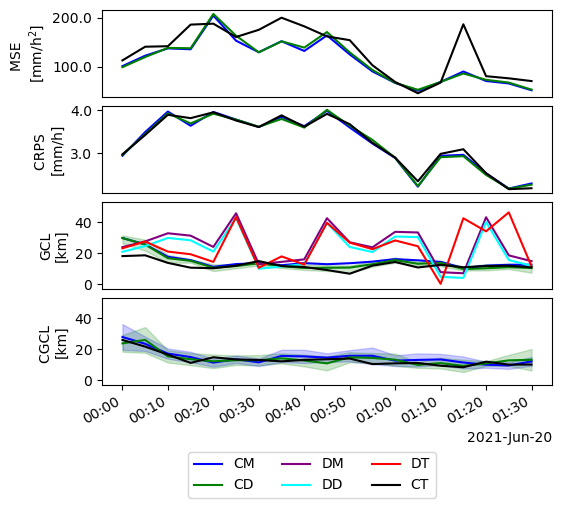

In [40]:
time_plot_start = '2021-06-20T00:00' #22.30
time_plot_end = '2021-06-20T01:30' # 01.30
to_mmh = 12

# index of time iterate, can be used to acess simulated fields
time_t1 = np.argmax((time_iterate == time_iterate.sel(time = time_plot_start, method = 'nearest')).values)
time_t2 = np.argmax((time_iterate == time_iterate.sel(time = time_plot_end, method = 'nearest')).values) + 1 #(to include last timestep)
fig, ax = plt.subplots(4, 1, figsize=(6, 5), sharex = True)

# MAE and its deviation:
time_plot = time_iterate.isel(time =slice(time_t1, time_t2))
rmse_mid = [np.mean((copula_midpoint['field_conditioned'][t]*to_mmh - ds_rad.sel(
    time =  time_iterate).rainfall_amount.values[t]*to_mmh)**2) for t in range(time_t1, time_t2)]
rmse_dereg = [np.mean((copula_dereg['field_conditioned'][t]*to_mmh - ds_rad.sel(
    time =  time_iterate).rainfall_amount.values[t]*to_mmh)**2) for t in range(time_t1, time_t2)]
rmse_true = [np.mean((copula_true['field_conditioned'][t]*to_mmh - ds_rad.sel(
    time =  time_iterate).rainfall_amount.values[t]*to_mmh)**2) for t in range(time_t1, time_t2)]

ax[0].plot(time_plot, rmse_mid, label = 'CM', color = 'blue')
ax[0].plot(time_plot, rmse_dereg, label = 'CD', color = 'green')
ax[0].plot(time_plot, rmse_true, label = 'CT', color = 'black')
ax[0].set_xlabel('')
ax[0].set_ylabel('MSE \n' + r'[mm/h$^2$]')

# CRPS
ax[1].plot(time_plot, CRPS_midpoint_r[time_t1:time_t2], label = 'midpoint', color = 'blue')
ax[1].plot(time_plot, CRPS_dereg_r[time_t1:time_t2], label = 'dereg', color = 'green')
ax[1].plot(time_plot, CRPS_true_r[time_t1:time_t2], label = 'true', color = 'black')
ax[1].set_xlabel('')
ax[1].set_ylabel('CRPS \n[mm/h]')

# gaussian correlation length
mid_plot = df_midpoint.loc[time_plot_start:time_plot_end]
dereg_plot = df_dereg.loc[time_plot_start:time_plot_end]
true_plot = df_true.loc[time_plot_start:time_plot_end]
eshelmid_plot = df_eshelmidpoint.loc[time_plot_start:time_plot_end]
esheldereg_plot = df_esheldereg.loc[time_plot_start:time_plot_end]
esheltrue_plot = df_esheltrue.loc[time_plot_start:time_plot_end]
time_plot = time_iterate.sel(time =slice(time_plot_start, time_plot_end))

mid_plot.median(axis = 1).to_xarray().plot(ax=ax[2], label = 'CM', color = 'blue')
dereg_plot.median(axis = 1).to_xarray().plot(ax=ax[2], label = 'CD', color = 'green')
eshelmid_plot.median(axis = 1).to_xarray().plot(ax=ax[2], label = 'DM', color = 'purple')
esheldereg_plot.median(axis = 1).to_xarray().plot(ax=ax[2], label = 'DD', color = 'cyan')
esheltrue_plot.mean(axis = 1).to_xarray().plot(ax=ax[2], label = 'DT', color = 'red')
true_plot.median(axis = 1).to_xarray().plot(ax=ax[2], label = 'CT', color = 'black')
ax[2].set_xlabel('')
ax[2].set_ylabel('GCL\n[km]')
ax[2].fill_between(time_plot, dereg_plot.mean(axis = 1).values - dereg_plot.std(axis = 1), dereg_plot.mean(axis = 1).values + dereg_plot.std(axis = 1), color='green', alpha = 0.2)

# Long CMLs
# mid_plot = df_midpoint_long.loc[time_plot_start:time_plot_end]
# dereg_plot = df_dereg_long.loc[time_plot_start:time_plot_end]
# true_plot = df_true_long.loc[time_plot_start:time_plot_end]
# eshelmid_plot = df_eshelmidpoint_long.loc[time_plot_start:time_plot_end]
# esheldereg_plot = df_esheldereg_long.loc[time_plot_start:time_plot_end]
# esheltrue_plot = df_esheltrue_long.loc[time_plot_start:time_plot_end]
# time_plot = time_iterate.sel(time =slice(time_plot_start, time_plot_end))

# mid_plot.median(axis = 1).to_xarray().plot(ax=ax[3], label = 'CM', color = 'blue')
# dereg_plot.median(axis = 1).to_xarray().plot(ax=ax[3], label = 'CD', color = 'green')
# eshelmid_plot.median(axis = 1).to_xarray().plot(ax=ax[3], label = 'DM', color = 'purple')
# esheldereg_plot.median(axis = 1).to_xarray().plot(ax=ax[3], label = 'DD', color = 'cyan')
# #esheltrue_plot.mean(axis = 1).to_xarray().plot(ax=ax[2], label = 'DT', color = 'red')
# true_plot.median(axis = 1).to_xarray().plot(ax=ax[3], label = 'CT', color = 'black')
# ax[3].set_xlabel('')
# ax[3].set_ylabel('GCL_l\n[km]')

# ax[2].fill_between(time_plot, mid_plot.mean(axis = 1).values - mid_plot.std(axis = 1), mid_plot.mean(axis = 1).values + mid_plot.std(axis = 1), color='blue', alpha = 0.2)
#ax[2].fill_between(time_plot, dereg_plot.mean(axis = 1).values - dereg_plot.std(axis = 1), dereg_plot.mean(axis = 1).values + dereg_plot.std(axis = 1), color='green', alpha = 0.2)
#ax[2].fill_between(time_plot, esheldereg_plot.mean(axis = 1).values - esheldereg_plot.std(axis = 1), esheldereg_plot.mean(axis = 1).values + esheldereg_plot.std(axis = 1), color='cyan', alpha = 0.2)
# ax[2].fill_between(time_plot, true_plot.mean(axis = 1).values - true_plot.std(axis = 1), true_plot.mean(axis = 1).values + true_plot.std(axis = 1), color='black', alpha = 0.2)


# conditioned gaussian correlation length
mid_plot = copula_midpoint['gaussian_range_conditioned'][time_t1: time_t2]
dereg_plot = copula_dereg['gaussian_range_conditioned'][time_t1: time_t2]
true_plot = copula_true['gaussian_range_conditioned'][time_t1: time_t2]
time_plot = time_iterate.isel(time =slice(time_t1, time_t2))

ax[3].plot(time_plot, mid_plot.mean(axis = 1), label = 'midpoint', color = 'blue')
ax[3].plot(time_plot, dereg_plot.mean(axis = 1), label = 'dereg', color = 'green')
ax[3].plot(time_plot, true_plot.mean(axis = 1), label = 'true', color = 'black')
ax[3].fill_between(time_plot, mid_plot.mean(axis = 1) - mid_plot.std(axis = 1), mid_plot.mean(axis = 1) + mid_plot.std(axis = 1), color='blue', alpha = 0.2)
ax[3].fill_between(time_plot, dereg_plot.mean(axis = 1) - dereg_plot.std(axis = 1), dereg_plot.mean(axis = 1) + dereg_plot.std(axis = 1), color='green', alpha = 0.2)
#ax[3].fill_between(time_plot, true_plot.mean(axis = 1) - true_plot.std(axis = 1), true_plot.mean(axis = 1) + true_plot.std(axis = 1), color='black', alpha = 0.2)
ax[3].set_xlabel('')
ax[3].set_ylabel('CGCL \n[km]')

ax[0].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[1].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax[3].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
#ax[4].yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

ax[0].tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False) 
ax[1].tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False) 
ax[2].tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False) 
#ax[3].tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False) 
ax[2].set_ylim(-3, 53)
ax[3].set_ylim(-3, 53)
#ax[4].set_ylim(-3, 43)

fig.autofmt_xdate()

handles, labels = ax[2].get_legend_handles_labels()
plt.subplots_adjust(bottom=0.23, top=0.98, wspace=0.1, hspace=0.1, left = 0.15)  # Adjust as necessary

fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.11), ncol=3)

plt.savefig('/home/erlend/Downloads/result_RM_timesteps.png', format = 'png', dpi=600)